In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

# XGBoost (if needed later)
import xgboost as xgb

# Evaluation
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, precision_recall_curve

# Train-test split (if needed separately later)
from sklearn.model_selection import train_test_split

# Load processed data
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').squeeze()
y_test = pd.read_csv('../data/y_test.csv').squeeze()

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")


Training Samples: 36168, Testing Samples: 9043


In [2]:
def evaluate_model(model_name, y_true, y_pred, y_proba, save_prefix=None):
    print(f"\n==== {model_name} ====")
    print("Classification Report:\n", classification_report(y_true, y_pred))

    auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    pr, rc, _ = precision_recall_curve(y_true, y_proba)

    # ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"{model_name} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_roc.png")
    plt.grid()
    plt.show()

    # PR Curve
    plt.figure()
    plt.plot(rc, pr, label=model_name)
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_prc.png")
    plt.grid()
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if save_prefix:
        plt.savefig(f"../results/plots/{save_prefix}_confusion_matrix.png")
    plt.show()

    return auc



==== Random Forest ====
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.99      0.94      7985
           1       0.62      0.19      0.29      1058

    accuracy                           0.89      9043
   macro avg       0.76      0.59      0.61      9043
weighted avg       0.87      0.89      0.86      9043



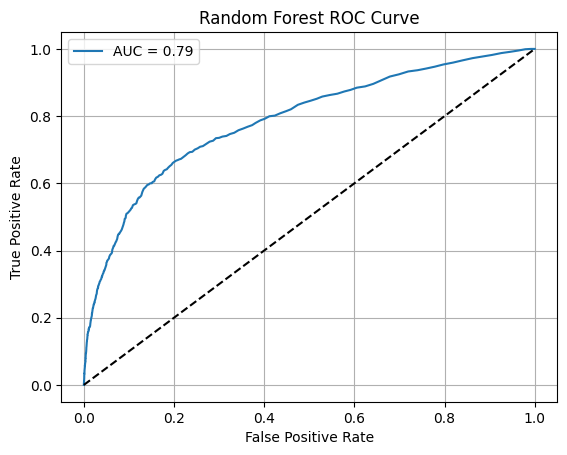

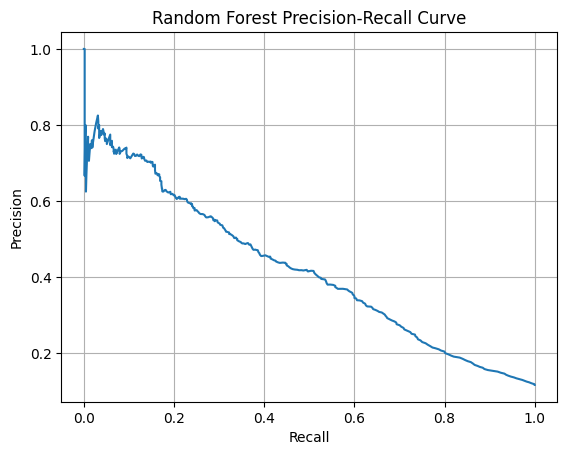

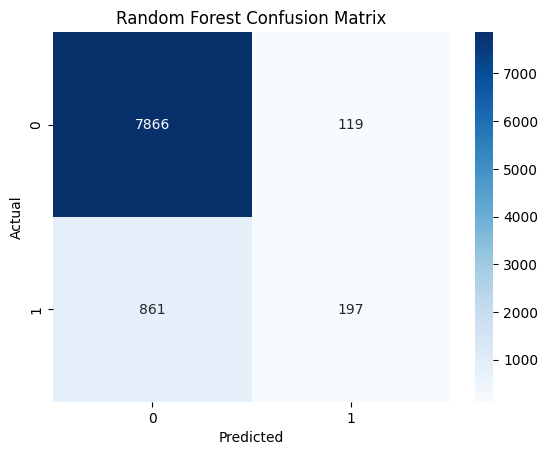

Random Forest AUC: 0.7882


In [3]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate using the helper
auc_rf = evaluate_model("Random Forest", y_test, y_pred_rf, y_proba_rf, save_prefix="rf")
print(f"Random Forest AUC: {auc_rf:.4f}")


c:\Users\Aditya\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



==== XGBoost ====
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90      7985
           1       0.37      0.60      0.46      1058

    accuracy                           0.83      9043
   macro avg       0.65      0.73      0.68      9043
weighted avg       0.87      0.83      0.85      9043



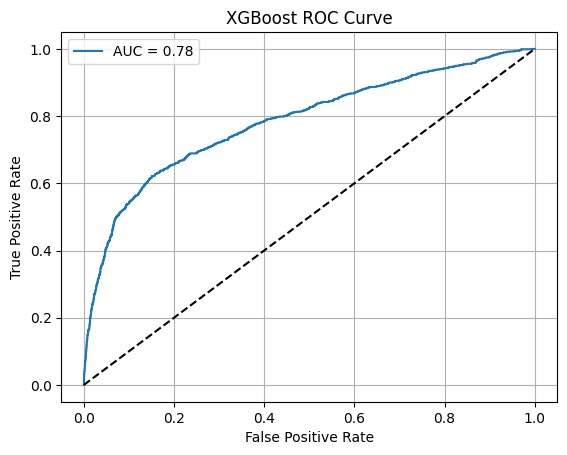

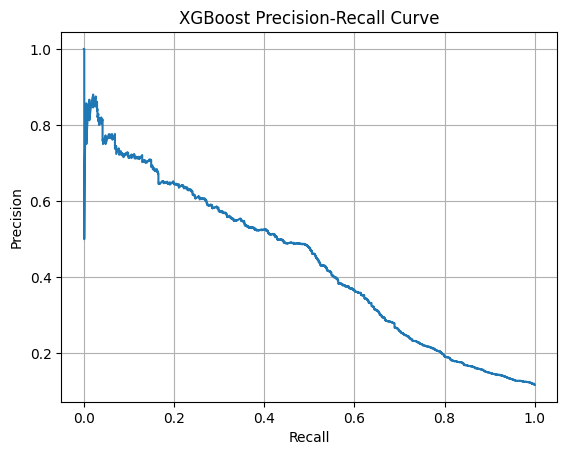

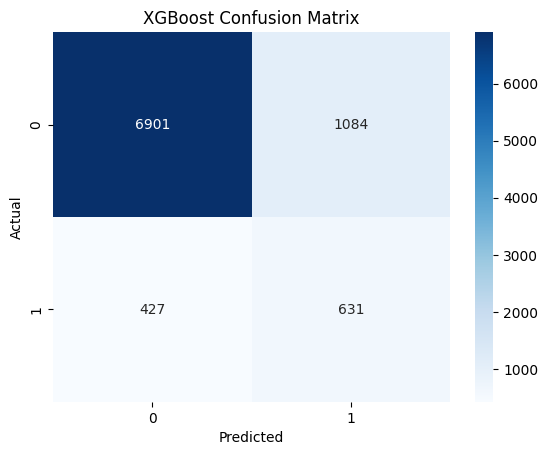

XGBoost AUC: 0.7844


In [4]:
# Gradient Boosting (XGBoost)
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # to balance classes
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate using helper
auc_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb, save_prefix="xgb")
print(f"XGBoost AUC: {auc_xgb:.4f}")


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



==== MLP Neural Network ====
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.61      0.23      0.33      1058

    accuracy                           0.89      9043
   macro avg       0.76      0.60      0.64      9043
weighted avg       0.87      0.89      0.87      9043



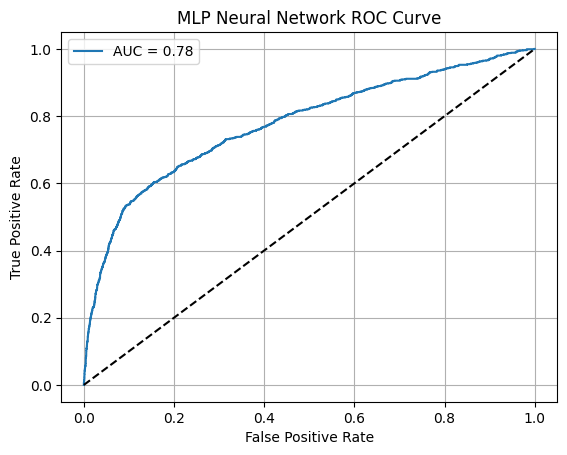

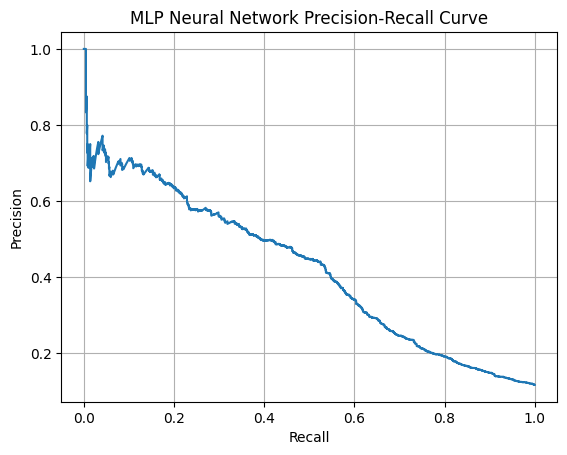

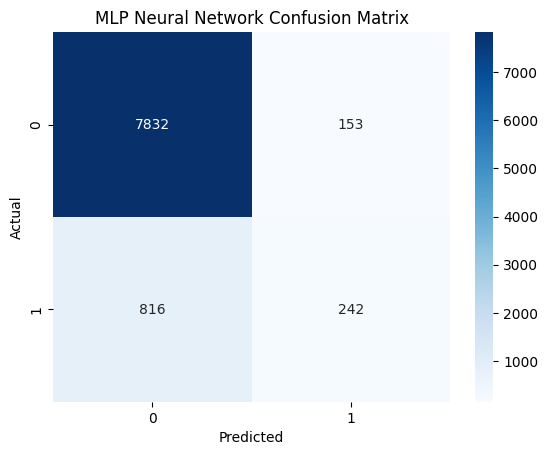

MLP AUC: 0.7765


In [6]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=300,
    early_stopping=True,
    random_state=42
)

mlp_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_mlp = mlp_model.predict(X_test_scaled)
y_proba_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
auc_mlp = evaluate_model("MLP Neural Network", y_test, y_pred_mlp, y_proba_mlp, save_prefix="mlp")
print(f"MLP AUC: {auc_mlp:.4f}")



==== Stacked Ensemble ====
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.65      0.24      0.35      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.61      0.64      9043
weighted avg       0.88      0.90      0.87      9043



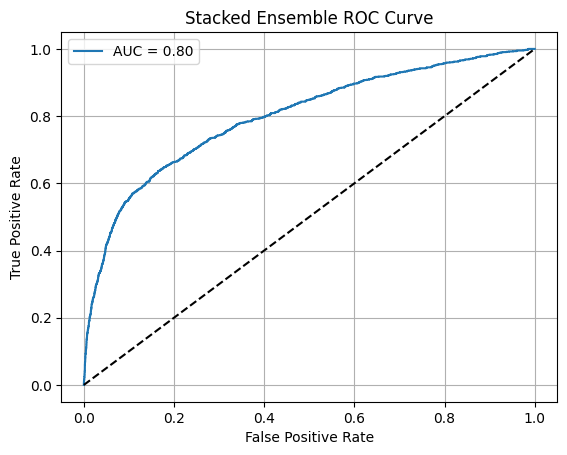

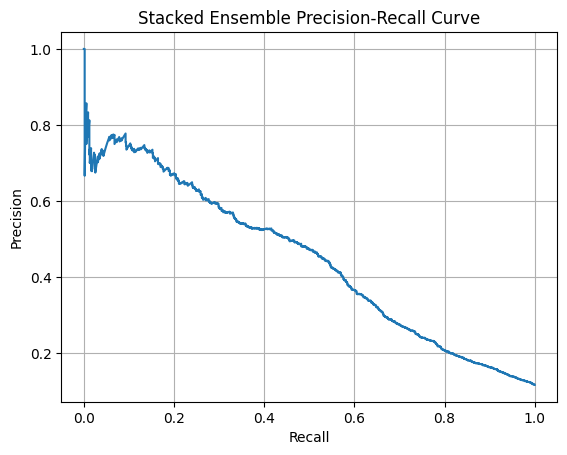

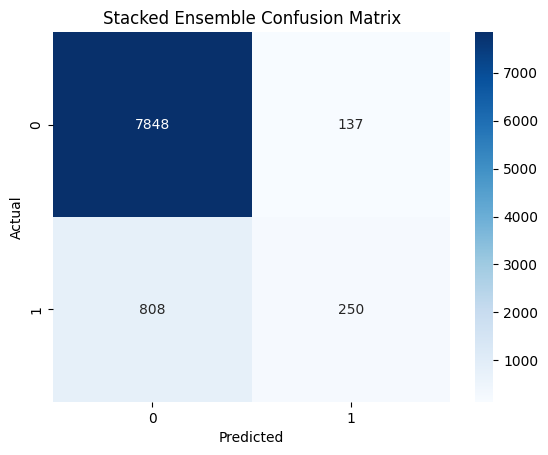

Stacked Ensemble AUC: 0.7989


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

# Recreate models for stacking (can't reuse already-fitted ones)
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)),
    ('xgb', xgb.XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )),
    ('mlp', MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu',
                          alpha=0.001, max_iter=300, early_stopping=True,
                          random_state=42))
]

# Meta-learner
meta_learner = LogisticRegression(max_iter=200)

# Stacking Classifier
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    passthrough=True,
    n_jobs=-1
)

# Fit on scaled inputs (since MLP needs scaling)
stacked_model.fit(X_train_scaled, y_train)

# Predict
y_pred_stack = stacked_model.predict(X_test_scaled)
y_proba_stack = stacked_model.predict_proba(X_test_scaled)[:, 1]

# Evaluate
auc_stack = evaluate_model("Stacked Ensemble", y_test, y_pred_stack, y_proba_stack, save_prefix="stacked")
print(f"Stacked Ensemble AUC: {auc_stack:.4f}")
